# RTF Model for predicting racket age using P1, P2 and P3, based on peaks features - Sound

### Model Description

This notebook implements a Random Tree Forest (RTF) model to predict the age of a racket (P1, P2, P3) based on sound features extracted from audio files. The workflow involves reading `.wav` files, extracting frequency peaks using FFT, and training the model using these features. The model's performance is evaluated using accuracy metrics and visualized through scatter plots and confusion matrices.

### Import libraries

In [1]:
import os
import sys
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

### Import Tools Functions

In [10]:
# Reach the project root
notebook_path = os.path.abspath('')
project_root = os.path.abspath(os.path.join(notebook_path, '../../../'))
functions_path = os.path.join(project_root, 'Functions')

# Add Functions folder
if functions_path not in sys.path:
    sys.path.append(functions_path)

In [ ]:
# Import functions

from extractPeakFromSignal import extractPeakFromSignal
from readWavFolder import readWavFolder
from spectrumFromWav import spectrumFromWav

## Main

In [4]:
# List of all the racket types and ages
raquetteTypeList = {"RB":0, "RO":1, "RR":2, "RV":3}
racket_ages = {"P1":1, "P2":2, "P3":3}

allWavFile=[]
allWavFileLabel=[]
allWavFileP1=[]
allWavFileP2=[]
allWavFileP3=[]

#P1
sampleRateFolderP1,allWavFileP1,filesP1 = readWavFolder("../../../Data/Sound/P1")

#P2
sampleRateFolderP2,allWavFileP2,filesP2 = readWavFolder("../../../Data/Sound/P2")

#P3
sampleRateFolderP3,allWavFileP3,filesP3 = readWavFolder("../../../Data/Sound/P3")


# Find the minimum length among the three lists
min_len = min(len(allWavFileP1), len(allWavFileP2), len(allWavFileP3))

# Reduce each list to the minimum length
allWavFileP1 = allWavFileP1[:min_len]
allWavFileP2 = allWavFileP2[:min_len]
allWavFileP3 = allWavFileP3[:min_len]

print("Len(allWavFileP1)",len(allWavFileP1),"Len(allWavFileP2)",len(allWavFileP2),"Len(allWavFileP3)",len(allWavFileP3))

for wavFile in allWavFileP1:
    allWavFile.append(wavFile)
    allWavFileLabel.append("P1")
for wavFile in allWavFileP2:
    allWavFile.append(wavFile)
    allWavFileLabel.append("P2")
for wavFile in allWavFileP3:
    allWavFile.append(wavFile)
    allWavFileLabel.append("P3")

Len(allWavFileP1) 213 Len(allWavFileP2) 213 Len(allWavFileP3) 213


Extract peaks

In [5]:
bestPeakHZAllWavFile = []
bestPeakAmplitudeAllWavFile = []
n_peak = 20

for wavFile in allWavFile:
    # Compute the spectrum using FFT
    spectrum = spectrumFromWav(wavFile)

    # Extract peaks from the spectrum
    peaks_HZ, peak_Amplitude = extractPeakFromSignal(signal=spectrum, num_peaks=n_peak)
    
    bestPeakHZAllWavFile.append(peaks_HZ)
    bestPeakAmplitudeAllWavFile.append(peak_Amplitude["peak_heights"])

    # Normalize the amplitude of the peaks
    bestPeakAmplitudeAllWavFile = [amp / np.max(amp) for amp in bestPeakAmplitudeAllWavFile]

In [6]:
# Combine features into X
X = np.hstack([np.array(bestPeakHZAllWavFile), np.array(bestPeakAmplitudeAllWavFile)])

# Encode string labels into integers
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(allWavFileLabel)

# Divide the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [7]:
# Define the hyperparameter ranges for Random Forest
n_estimators_range = [10, 50, 100]
max_depth_range = [None, 10, 20, 30]
min_samples_split_range = [2, 5, 10]

results = []

# Test different hyperparameters
for n_estimators in n_estimators_range:
    for max_depth in max_depth_range:
        for min_samples_split in min_samples_split_range:
            rf = RandomForestClassifier(
                n_estimators=n_estimators,
                max_depth=max_depth,
                min_samples_split=min_samples_split,
                random_state=42
            )
            rf.fit(X_train, y_train)
            y_pred = rf.predict(X_test)
            y_train_pred = rf.predict(X_train)

            results.append({
                'n_estimators': n_estimators,
                'max_depth': max_depth,
                'min_samples_split': min_samples_split,
                'accuracy_train': accuracy_score(y_train, y_train_pred),
                'accuracy_test': accuracy_score(y_test, y_pred)
            })

# Convert the results to a DataFrame
results_df = pd.DataFrame(results)

# Sort the results by accuracy_test in descending order
sorted_results_df = results_df.sort_values(by='accuracy_test', ascending=False)

print(sorted_results_df)

# Export sorted results to a CSV file
sorted_results_df.to_csv("S_RTF_Age_P1.P2.P3_Peaks.csv", index=False)

    n_estimators  max_depth  min_samples_split  accuracy_train  accuracy_test
34           100       30.0                  5        0.998043       0.914062
31           100       20.0                  5        0.998043       0.914062
27           100       10.0                  2        0.998043       0.914062
25           100        NaN                  5        0.998043       0.914062
18            50       20.0                  2        1.000000       0.906250
16            50       10.0                  5        0.988258       0.906250
32           100       20.0                 10        0.992172       0.906250
29           100       10.0                 10        0.982387       0.906250
28           100       10.0                  5        0.988258       0.906250
26           100        NaN                 10        0.992172       0.906250
23            50       30.0                 10        0.986301       0.906250
22            50       30.0                  5        0.998043  

## Results and Visualisation

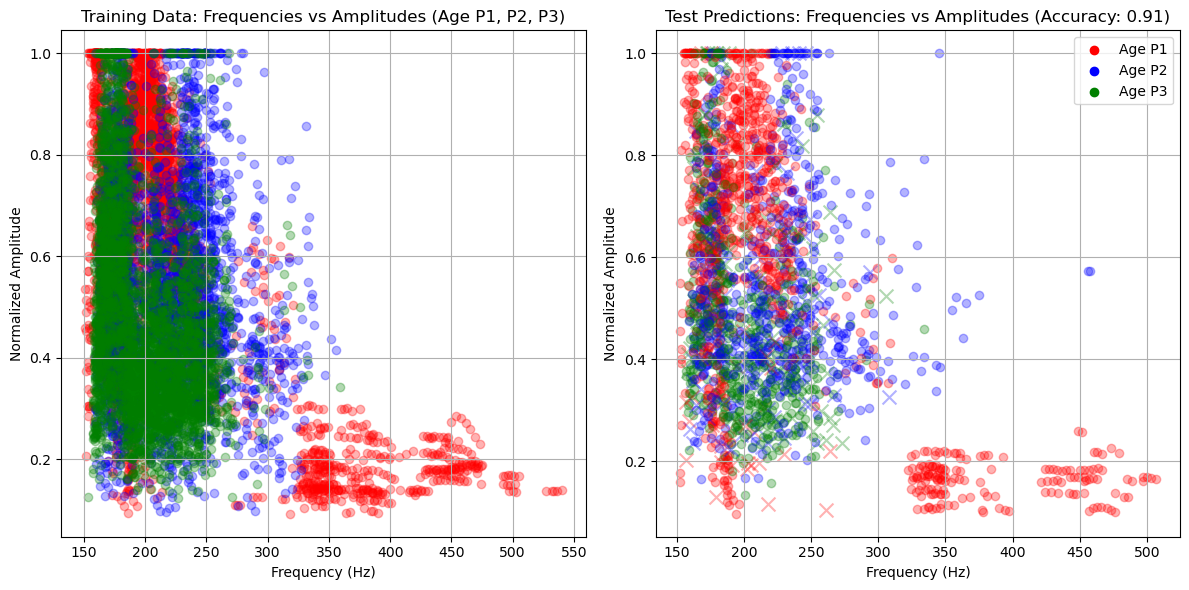

In [8]:
# Define a color map for the labels
colors = ['red', 'blue', 'green']
ageList = {"P1": 1, "P2": 2, "P3": 3}
label_names = list(ageList.keys())

# Create a scatter plot for the training data
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1) # First subplot for training data
for label_idx, label_name in enumerate(label_names):
    # Filter data points for the current label
    label_data = X_train[y_train == label_idx]
    for sample in label_data:
        # Add 150Hz because of the filter and filter frequencies <= 1250 Hz
        frequencies = sample[:n_peak] + 150
        amplitudes = sample[n_peak:]
        mask = frequencies <= 550
        plt.scatter(frequencies[mask], amplitudes[mask], color=colors[label_idx], alpha=0.3)

plt.title("Training Data: Frequencies vs Amplitudes (Age P1, P2, P3)")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Normalized Amplitude")
plt.grid()

# Create a scatter plot for the test data with predictions
plt.subplot(1, 2, 2) # Second subplot for test data with predictions
y_pred = rf.predict(X_test) # Get predictions for test data

for i, sample in enumerate(X_test):
    true_label = y_test[i]
    pred_label = y_pred[i]

    # Add 150Hz because of the filter and filter frequencies <= 1250 Hz
    frequencies = sample[:n_peak] + 150
    amplitudes = sample[n_peak:]
    mask = frequencies <= 550

    # Plot with solid color if prediction is correct, otherwise use a different marker
    if true_label == pred_label:
        plt.scatter(frequencies[mask], amplitudes[mask], color=colors[pred_label], alpha=0.3)
    else:
        # Use 'x' marker for incorrect predictions
        plt.scatter(frequencies[mask], amplitudes[mask], color=colors[pred_label], marker='x', s=100, alpha=0.3)

# Add a legend
for label_idx, label_name in enumerate(label_names):
    plt.scatter([], [], color=colors[label_idx], label=f"Age {label_name}")

plt.legend()
plt.title(f"Test Predictions: Frequencies vs Amplitudes (Accuracy: {accuracy_score(y_test, y_pred):.2f})")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Normalized Amplitude")
plt.grid()

plt.tight_layout()
plt.show()

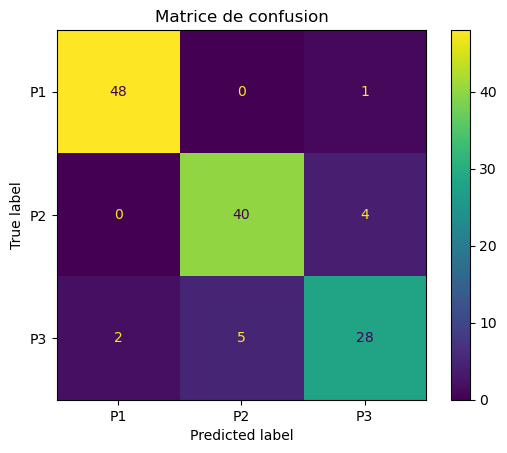

In [9]:
from sklearn.metrics import ConfusionMatrixDisplay

# Afficher la matrice de confusion
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels=label_encoder.classes_)
plt.title("Matrice de confusion")
plt.show()